In [1]:
""" 
Ramsey Villarreal
Created 7/3/2018
"""

import os, sys
import cv2
from keras.layers import Dense, Input, Activation, Flatten, Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
import gc

C:\Users\ramse\AppData\Local\conda\conda\envs\Tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#set random seeds
np.random.seed(11)
tf.set_random_seed(11)

In [3]:
# process_img takes an image path and preprocesses it
def process_img(path):
    #read image 
    img = cv2.imread(path)
    #resize image to VGG input
    img = cv2.resize(img,(224,224))
    # Convert from bgr to rgb 
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # convert to numpy float then devide by 255 to normalize
    img = img.astype(np.float32)/255
    return img

In [4]:
def read_img(directory):
    labels = []
    images = []
    # use os.walk to read files in given directory
    for root, dirs, files in os.walk(directory):
        for f in files:
            # if the X-Ray is normal, give is 0 category
            if('NORMAL' in root and 'jpeg' in f):
                label = to_categorical(0,num_classes=2)
                labels.append(label)
                path = os.path.join(root,f)
                images.append(process_img(path))
            # elif the X-Ray contains pneumonia, give it 1 category
            elif('PNEUMONIA' in root and 'jpeg' in f):
                label = to_categorical(1,num_classes=2)
                labels.append(label)
                path = os.path.join(root,f) 
                images.append(process_img(path))
                
    return images, labels

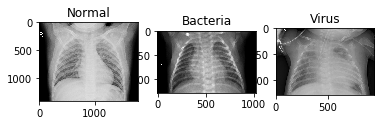

In [5]:
img_dir = ('B:\\Programming\\Pneumonia\\chest-xray-pneumonia\\chest_xray\\chest_xray')
test_dir = img_dir + '\\test'
train_dir = img_dir + '\\train'
val_dir = img_dir + '\\val'

normal_img = cv2.imread(val_dir + '\\NORMAL\\NORMAL2-IM-1427-0001.jpeg')
bacteria_img = cv2.imread(test_dir + '\\PNEUMONIA\\person78_bacteria_387.jpeg')
virus_img = cv2.imread(test_dir + '\\PNEUMONIA\\person1_virus_6.jpeg')

# read images from test, train, and validate directories
# test_img, test_label = read_img(test_dir)
train_img, train_label = read_img(train_dir)
# val_img, val_label = read_img(val_dir)
                
                
#Turn lists into numpy arrays 
# test_label = np.array(test_label)
# test_img = np.array(test_img)             
train_label = np.array(train_label)
train_img = np.array(train_img)               
# val_label = np.array(val_label)
# val_img = np.array(val_img)


f, ax = plt.subplots(1,3)
ax[0].imshow(normal_img)
ax[0].set_title('Normal')
ax[1].imshow(bacteria_img)
ax[1].set_title('Bacteria')
ax[2].imshow(virus_img)
ax[2].set_title('Virus')

plt.show()



In [6]:
def build_model():
    # load VGG16 model with imagenet weights
    model = VGG16(weights='imagenet',include_top=True)
    model.summary()

    for l in model.layers:
        l.trainable=False
    # pop the last 3 fully connected layers
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()
    
    orig = model.input

    # add fully connected layers and output of 2 categories
    new_model =Dense(4096,activation='relu',name='fc1')(model.get_layer('flatten').output)
    new_model =Dense(1024,activation='relu',name='fc2')(new_model)
    new_model =Dense(512,activation='relu',name='fc3')(new_model)
    new_model =Dense(2,activation='softmax',name='output')(new_model)
    model = Model(orig,new_model)
    model.summary()
   
    return model


In [7]:
model = build_model()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
# make training data suitable shape to train model
train_data = np.zeros((len(train_img), 224, 224, 3), dtype=np.float32)
train_labels = np.zeros((len(train_label),2), dtype=np.float32)
x=0
for l in train_img:
    train_data[x] = l
    train_labels[x] = train_label[x]
    x+=1
    

In [9]:
# delete some unused variables to clear up some resources before loading training model

del(train_img)
del(train_label)
gc.collect()

1548

In [10]:
# compile model with Adam optimizer and binary_crossentropy loss
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])

# train model to training data
model.fit(train_data,train_labels, batch_size=15, epochs=10, shuffle=True)

Epoch 1/10
5216/5216 [==============================] - 60s 11ms/step - loss: 0.1223 - acc: 0.9551
Epoch 2/10
5216/5216 [==============================] - 58s 11ms/step - loss: 0.0564 - acc: 0.9797
Epoch 3/10
5216/5216 [==============================] - 58s 11ms/step - loss: 0.0437 - acc: 0.9858
Epoch 4/10
5216/5216 [==============================] - 58s 11ms/step - loss: 0.0395 - acc: 0.9852
Epoch 5/10
5216/5216 [==============================] - 58s 11ms/step - loss: 0.0322 - acc: 0.9883
Epoch 6/10
5216/5216 [==============================] - 58s 11ms/step - loss: 0.0180 - acc: 0.9939
Epoch 7/10
5216/5216 [==============================] - 58s 11ms/step - loss: 0.0185 - acc: 0.9925
Epoch 8/10
5216/5216 [==============================] - 58s 11ms/step - loss: 0.0223 - acc: 0.9916
Epoch 9/10
5216/5216 [==============================] - 58s 11ms/step - loss: 0.0153 - acc: 0.9950
Epoch 10/10
5216/5216 [==============================] - 58s 11ms/step - loss: 0.0155 - acc: 0.9944


In [11]:
# evaluate model on test images
test_img, test_label = read_img(test_dir)
test_label = np.array(test_label)
test_img = np.array(test_img)  
metrics = model.evaluate(test_img,test_label)
for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(metrics[i]))

624/624 [==============================] - 5s 7ms/step
loss: 1.2797108408140048
acc: 0.8028846153846154
